In this [experiment](G_Converting_Dates_to_Standard_Format_via_LSTM_with_Attention_Layer.ipynb), I implemented a sequence-to-sequence model with two LSTM layers and an attention layer to perform "date translation" task - converting dates in any format into a standard YYYY-MM-DD format, based on the starting code, instructions, training sample and utility functions from the [Deep Learning - Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course (by DeepLearning.AI on Coursera).

Here are some examples of expected conversion:
```
source: 3 May 1979
output: 1979-05-03

source: 5 April 09
output: 2009-04-05

source: 21th of August 2016
output: 2016-08-21

source: Tue 10 Jul 2007
output: 2007-07-10

source: Saturday May 9 2018
output: 2018-05-09

source: March 3 2001
output: 2001-03-03

source: March 3rd 2001
output: 2001-03-03

source: 1 March 2001
output: 2001-03-01
```

The attention mechanism tells the model which character in the input string to pay more attention as it generates the output string (standardized date format).

That's just like when you're translating from English to another language, sometimes you have to stop and look back to see which parts you should pay more attention to so that you can have more accurate translation.

The attention model is illustrated in this diagram (from the Coursera assignment):

![attn_model.png](images%2Fattn_model.png)

Please refer to the course lectures and assignments on Coursera for the mathematical details of the attention layer, as shown in the diagram below:

![attn_mechanism.png](images%2Fattn_mechanism.png)

You can also visualize the attention weights that the model, upon trying to generate each character in the output, was paying to each character in the input string.

Note that when generating the "year" part of the output, the model was paying attention to the year in the input. Similarly for the "month" and "date" parts.

![sample_attention_weight_visualization2.png](sample_attention_weight_visualization2.png)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd /content/drive/Othercomputers/My Laptop/T_Repo/C5_W3_Assignment1/Files/home/jovyan/work/W3A1
# %ls

/content/drive/Othercomputers/My Laptop/T_Repo/C5_W3_Assignment1/Files/home/jovyan/work/W3A1
G_Converting_Dates_to_Standard_Format_via_LSTM_with_Attention_Layer.ipynb
generateTestCases.py
images/
models/
Neural_machine_translation_with_attention_v4a.ipynb
nmt_utils.py
notebook2script.py
O_greyhat_Neural_machine_translation_with_attention_v4a.ipynb
__pycache__/
PythonScript/
readme.md
sample_attention_weight_visualization.png
test_utils.py
T_Neural_machine_translation_with_attention_v4a.ipynb


In [3]:
%pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00


In [4]:
from keras.api._v2.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.api._v2.keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.api._v2.keras.optimizers import Adam
from keras.api._v2.keras.utils import to_categorical
from keras.api._v2.keras.models import load_model, Model
import keras.api._v2.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Importing the dataset
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 25309.34it/s]


In [6]:
dataset[:10]

[('27 jun 1992', '1992-06-27'),
 ('20.07.70', '1970-07-20'),
 ('7/16/14', '2014-07-16'),
 ('thursday february 13 1986', '1986-02-13'),
 ('sunday november 19 1989', '1989-11-19'),
 ('saturday june 14 1980', '1980-06-14'),
 ('wednesday july 19 2000', '2000-07-19'),
 ('23 sep 1978', '1978-09-23'),
 ('15 sep 1976', '1976-09-15'),
 ('friday may 14 1993', '1993-05-14')]

In [7]:
Tx = 30  # max length of the input string
Ty = 10  # length of output string (standardized date format)
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [8]:
# Examples of one-hot encoding of the inputs and outputs
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 27 jun 1992
Target date: 1992-06-27

Source after preprocessing (indices): [ 5 10  0 22 31 25  0  4 12 12  5 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  3  0  1  7  0  3  8]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


# Building the attention layer

In [9]:
# # Defined shared layers as global variables

repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation="tanh")
densor2 = Dense(1, activation="relu")
activator = Activation(softmax, name="attention_weights")  # using the custom softmax function (axis=1) loaded in this notebook
dotor = Dot(axes=1)

In [10]:

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a, s_prev])  # shape (m, Tx, n_s + 2*n_a)
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)  # shape (m, Tx, 10)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)  # shape (m, Tx, 1)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)  # shape (m, Tx, 1)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    # 'a' has shape (m, Tx, 2*n_a)
    context = dotor([alphas, a])

    return context

# Building the LSTM model

In [11]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.
post_activation_LSTM_cell = LSTM(n_s, return_state=True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [12]:

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """

    # Define the inputs of your model with a shape (Tx, human_vocab_size)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    # initial hidden state
    s0 = Input(shape=(n_s, ), name='s0')
    # initial cell state
    c0 = Input(shape=(n_s,), name='c0')
    # hidden state
    s = s0
    # cell state
    c = c0

    # Initialize empty list of outputs
    outputs = []

    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(units=n_a, return_sequences=True), )(X)

    # Step 2: Iterate for Ty steps
    for t in range(Ty):

        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)

        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector. (≈ 1 line)
        # Don't forget to pass: initial_state = [hidden state, cell state]
        # Remember: s = hidden state, c = cell state
        _, s, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])

        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)

        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)

    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)

    return model

In [13]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

# Training

In [14]:
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, weight_decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
s0 = np.zeros(shape=(m, n_s))
c0 = np.zeros(shape=(m, n_s))
outputs = list(Yoh.swapaxes(0, 1))

In [16]:
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Epoch 1/20
100/100 [==============================] - 20s 24ms/step - loss: 15.5678 - dense_2_loss: 1.0116 - dense_2_1_loss: 0.8395 - dense_2_2_loss: 1.6737 - dense_2_3_loss: 2.5987 - dense_2_4_loss: 0.6740 - dense_2_5_loss: 1.1973 - dense_2_6_loss: 2.5786 - dense_2_7_loss: 0.8011 - dense_2_8_loss: 1.6383 - dense_2_9_loss: 2.5551 - dense_2_accuracy: 0.6035 - dense_2_1_accuracy: 0.7566 - dense_2_2_accuracy: 0.3135 - dense_2_3_accuracy: 0.1048 - dense_2_4_accuracy: 0.8837 - dense_2_5_accuracy: 0.4174 - dense_2_6_accuracy: 0.0749 - dense_2_7_accuracy: 0.9116 - dense_2_8_accuracy: 0.2634 - dense_2_9_accuracy: 0.1002
Epoch 2/20
100/100 [==============================] - 2s 24ms/step - loss: 7.7223 - dense_2_loss: 0.0941 - dense_2_1_loss: 0.0806 - dense_2_2_loss: 0.8526 - dense_2_3_loss: 1.7051 - dense_2_4_loss: 0.0115 - dense_2_5_loss: 0.2381 - dense_2_6_loss: 1.7593 - dense_2_7_loss: 0.0094 - dense_2_8_loss: 0.9580 - dense_2_9_loss: 2.0137 - dense_2_accuracy: 0.9747 - dense_2_1_accuracy: 0

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = source.swapaxes(0, 1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output), "\n")

1/1 [==============================] - 4s 4s/step
source: 3 May 1979
output: 1979-05-03 

1/1 [==============================] - 0s 30ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 29ms/step
source: 21th of August 2016
output: 2016-08-21 

1/1 [==============================] - 0s 31ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 33ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 32ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 30ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 34ms/step
source: 1 March 2001
output: 2001-03-01 


# Visualizing Attention Weights

This helper function (from the Coursera starting code) allows us to visualize the computed $\alpha^{\langle t, t' \rangle}$

1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

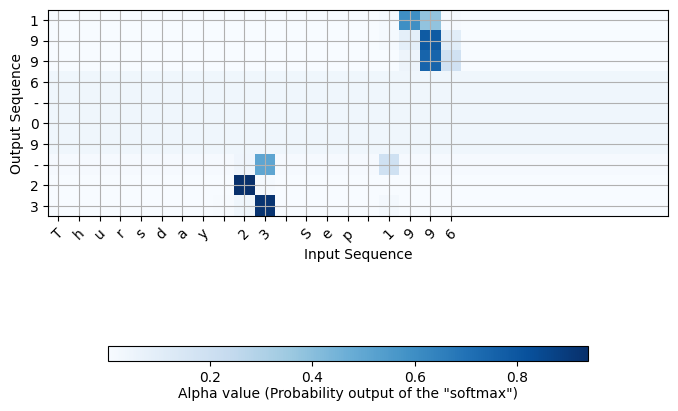

In [18]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Thursday 23 Sep 1996", num = 7, n_s = 64);